In [11]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from itertools import combinations

In [13]:
d= np.loadtxt('prices.txt', dtype=float)
d= d.T
d

array([[38.25, 38.11, 37.9 , ..., 36.58, 36.43, 36.24],
       [69.06, 69.98, 69.56, ..., 50.8 , 51.19, 50.64],
       [62.08, 62.39, 62.82, ..., 44.25, 44.02, 43.43],
       ...,
       [24.02, 24.04, 23.76, ..., 15.81, 15.75, 15.74],
       [76.03, 76.05, 75.66, ..., 80.93, 80.8 , 80.5 ],
       [27.5 , 27.54, 27.55, ..., 31.83, 31.78, 31.59]])

In [15]:
returns = np.diff(np.log(d),axis = 1)

In [17]:
cor_matrix = np.corrcoef(returns)

In [23]:
def find_most_correlated_groups(cor_matrix, min_size=3, max_size=5, top_n=10):
    n = cor_matrix.shape[0]
    group_scores = []

    for size in range(min_size, max_size + 1):
        print(f"Checking groups of size {size} ...")
        for group in combinations(range(n), size):
            sub_corr = cor_matrix[np.ix_(group, group)]
            # Sum absolute off-diagonal correlations:
            off_diag_sum = np.sum(np.abs(sub_corr)) - np.sum(np.abs(np.diag(sub_corr)))
            group_scores.append((group, off_diag_sum))

    # Sort by score descending
    group_scores.sort(key=lambda x: x[1], reverse=True)

    return group_scores[:top_n]


In [25]:
top_groups=find_most_correlated_groups(cor_matrix)
top_groups

Checking groups of size 3 ...
Checking groups of size 4 ...
Checking groups of size 5 ...


[((7, 13, 17, 18, 38), 1.5607187235282538),
 ((7, 9, 13, 38, 39), 1.5571558253648492),
 ((7, 13, 18, 38, 44), 1.5384101378644912),
 ((7, 18, 38, 39, 44), 1.5166537433504015),
 ((7, 13, 18, 37, 38), 1.5118880090270173),
 ((13, 17, 18, 38, 44), 1.5007162342696745),
 ((7, 13, 18, 38, 39), 1.4991865209668465),
 ((7, 13, 18, 23, 38), 1.4937116600444984),
 ((7, 9, 38, 39, 49), 1.4871547571934425),
 ((7, 9, 13, 38, 44), 1.4787144704382325)]

In [27]:
def compute_spread_zscore_group(prices):
    """
    prices: list or array of shape (m, n_obs), where
        m = number of stocks in group,
        n_obs = number of time points (prices over time)
    
    Regress prices[0] on prices[1:], compute spread residual and z-score.
    """
    prices = np.array(prices)
    y = prices[0]                # target asset prices, shape (n_obs,)
    X = prices[1:].T             # other assets, shape (n_obs, m-1)
    
    beta, _, _, _ = np.linalg.lstsq(X, y, rcond=None)
    spread = y - X.dot(beta)
    z = (spread - np.mean(spread)) / np.std(spread)
    
    return spread, z, beta

def simulate_trades_group(z, entry=1.0, exit=0.0):
    positions = np.zeros(len(z))
    for t in range(1, len(z)):
        if z[t-1] < -entry:
            positions[t] = 1  # Long spread
        elif z[t-1] > entry:
            positions[t] = -1  # Short spread
        elif abs(z[t-1]) < exit:
            positions[t] = 0  # Exit position
        else:
            positions[t] = positions[t-1]  # Hold previous position
    return positions

def compute_pnl_group(positions, spread):
    spread_diff = np.diff(spread)
    pnl = positions[:-1] * spread_diff  # lag position by 1
    return np.cumsum(pnl)


In [31]:
# Suppose data shape = (n_assets, n_days)
# Select group indices for group size m
group_indices = [0, 2, 5, 7]  # for example 4 stocks

group_prices = [d[i] for i in group_indices]  # list of arrays

spread, z, beta = compute_spread_zscore_group(group_prices)
positions = simulate_trades_group(z, entry=1.0, exit=0.0)
pnl = compute_pnl_group(positions, spread)
pnl

array([-0.        ,  0.46301833,  0.89877767,  0.80300109,  0.90763339,
        1.0763643 ,  0.84426466,  0.66399286,  0.66384117,  0.37087464,
        0.17937184,  0.4248656 ,  0.62959137,  0.42294697,  1.05246993,
        0.76439344,  1.04875505,  0.59126433,  0.35187794,  0.13501965,
        0.28600575,  0.77705429,  0.87233673,  1.20024653,  1.11736232,
        1.32360082,  1.45186944,  1.36145491,  1.91561082,  2.20792457,
        2.27414481,  2.17969855,  2.42666396,  2.51706029,  2.67135854,
        3.52255019,  3.3292802 ,  3.20369078,  2.57304592,  2.18617279,
        2.41019273,  2.44989647,  2.90589481,  2.99742398,  3.1829424 ,
        3.28415219,  3.27830682,  3.42756233,  3.45427815,  3.25528081,
        2.78155654,  2.93763948,  2.81936284,  3.16955282,  3.38190945,
        3.04015963,  2.71972768,  3.01184595,  2.53829556,  2.06665584,
        2.15031631,  1.85702652,  2.02414524,  2.3017406 ,  2.04619735,
        1.86648186,  1.85633337,  1.89056117,  2.10746979,  1.84

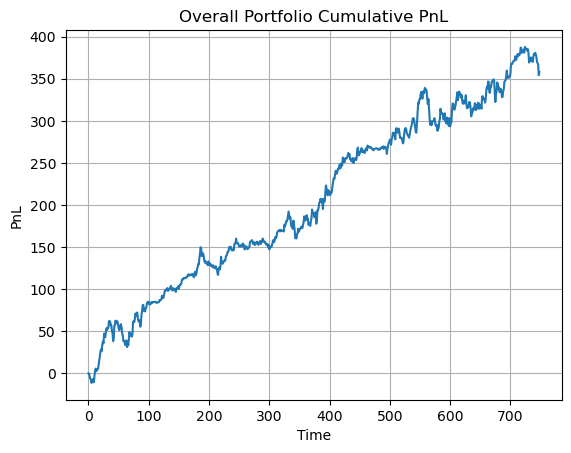

In [39]:
overall_pnl = None
for a in range(9):  # Or len(top_pairs)
    group_indices = top_groups[a][0]
    group_prices = [d[i] for i in group_indices]
    



    spread, z, beta = compute_spread_zscore_group(group_prices)
    positions = simulate_trades_group(z, entry=1.0, exit=0.0)
    pnl = compute_pnl_group(positions, spread)

    # Pad pnl to the same length if needed
    pnl = np.pad(pnl, (0, d.shape[1] - 1 - len(pnl)), constant_values=0)

    if overall_pnl is None:
        overall_pnl = pnl
    else:
        overall_pnl += pnl  # aggregate all pnls into one

# Plot the overall portfolio PnL
plt.plot(overall_pnl)
plt.title("Overall Portfolio Cumulative PnL")
plt.xlabel("Time")
plt.ylabel("PnL")
plt.grid(True)
plt.show()

In [41]:
def analyze_pnl(pnl):
    returns = np.diff(pnl)
    avg_daily_return = np.mean(returns)
    volatility = np.std(returns)
    sharpe_ratio = avg_daily_return / volatility * np.sqrt(252)  # assume 252 trading days
    max_drawdown = np.max(np.maximum.accumulate(pnl) - pnl)

    print(f"Total PnL: {pnl[-1]:.2f}")
    print(f"Average Daily Return: {avg_daily_return:.4f}")
    print(f"Volatility: {volatility:.4f}")
    print(f"Sharpe Ratio: {sharpe_ratio:.2f}")
    print(f"Max Drawdown: {max_drawdown:.2f}")
    print(f"Final score: {avg_daily_return-0.1*volatility}")

analyze_pnl(overall_pnl)

Total PnL: 358.09
Average Daily Return: 0.4787
Volatility: 4.1988
Sharpe Ratio: 1.81
Max Drawdown: 51.11
Final score: 0.058852402285316574
